In [13]:
#confirm the environment

import sys
print(sys.executable)

/Users/omowonuolaakintola/Software/anaconda3/envs/sar_snic/bin/python


In [14]:
#install all necessary packages

import os
import rasterio
import subprocess
from PIL import Image
from skimage.io import imread,imshow
import numpy as np
from timeit import default_timer as timer
from _snic.lib import SNIC_main
from cffi import FFI

import matplotlib.pyplot as plt
from skimage.measure import regionprops_table
import pandas as pd
from skimage.segmentation import mark_boundaries
from skimage.util import map_array
import matplotlib.colors as mcolors
from sklearn.ensemble import RandomForestClassifier

In [15]:
def segment(imgname,numsuperpixels,compactness,doRGBtoLAB):
	#--------------------------------------------------------------
	# read image and change image shape from (h,w,c) to (c,h,w)
	#--------------------------------------------------------------
	if isinstance(imgname, np.ndarray):
		img = imgname
	else:
		img = np.asarray(Image.open(imgname))

	#img = Image.open(imgname)
	# img = imread(imgname)
	#img = np.asarray(img)
	print(img.shape)

	dims = img.shape
	h,w,c = dims[0],dims[1],1
	if len(dims) > 1:
	#if len(dims) == 2:
		#h,w = dims
		#c = 1
		#img = img[np.newaxis, :, :] # (H,W) -> (1, H, W)
	#elif len(dims) == 3:
		#h,w,c = dims
		c = dims[2]
		img = img.transpose(2,0,1) # check this and change to np.transpose
		print(c, "channels")

	#-------------------------------------------------------------- 
	# Reshape image to a single dimensional vector
	#--------------------------------------------------------------
	img = img.reshape(-1).astype(np.double)
	labels = np.zeros((h,w), dtype = np.int32)
	numlabels = np.zeros(1,dtype = np.int32)
	#--------------------------------------------------------------
	# Prepare the pointers to pass to the C function
	#--------------------------------------------------------------
	ffibuilder = FFI()
	pinp = ffibuilder.cast("double*", ffibuilder.from_buffer(img))
	plabels = ffibuilder.cast("int*", ffibuilder.from_buffer(labels.reshape(-1)))
	pnumlabels = ffibuilder.cast("int*", ffibuilder.from_buffer(numlabels))

	
	start = timer()
	SNIC_main(pinp,w,h,c,numsuperpixels,compactness,doRGBtoLAB,plabels,pnumlabels)
	end = timer()

	#--------------------------------------------------------------
	# Collect labels
	#--------------------------------------------------------------
	print("number of superpixels: ", numlabels[0])
	print("time taken in seconds: ", end-start)

	return labels.reshape(h,w),numlabels[0]


	# lib.SNICmain.argtypes = [np.ctypeslib.ndpointer(dtype=POINTER(c_double),ndim=2)]+[c_int]*4 +[c_double,c_bool,ctypes.data_as(POINTER(c_int)),ctypes.data_as(POINTER(c_int))]


In [16]:
def drawBoundaries(imgname,labels,numlabels):

	if isinstance(imgname, np.ndarray):
		img = imgname
	else:
		img = Image.open(imgname)	
		img = np.array(img)
	
	print(img.shape)

	ht,wd = labels.shape

	for y in range(1,ht-1):
		for x in range(1,wd-1):
			if labels[y,x-1] != labels[y,x+1] or labels[y-1,x] != labels[y+1,x]:
				img[y,x,:] = 0

	return img
	
# Before calling this function, please compile the C code using
# "python compile.py" on the command line

In [137]:
def snicdemo():
	#--------------------------------------------------------------
	# Set parameters and call the C function
	#--------------------------------------------------------------
	numsuperpixels = 500
	compactness = 20.0
	doRGBtoLAB = False # only works if it is a three channel image
	# imgname = "/Users/achanta/Pictures/classics/lena.png"
	#imgname = 'bee.png'
	#imgname = ("../../Data/drone_large.png")
	#imgname = ("../../Data/kakumaa.tif")
	with rasterio.open("../../data/Bangladesh_kameng_river.tif") as src:
		imgname = src.read()
		sar = src.read()
		sar = np.transpose(sar, (1, 2, 0))
		imgname = sar.astype(np.uint8)

	labels,numlabels = segment(imgname,numsuperpixels,compactness,doRGBtoLAB)
	print("Unique segment labels:", np.unique(labels))
	print("Total segments:", len(np.unique(labels)))
	#--------------------------------------------------------------
	# Display segmentation result
	#------------------------------------------------------------
	segimg = drawBoundaries(imgname,labels,numlabels)

	# Image.fromarray(segimg).show()
	Image.fromarray(segimg).save("../../image/sar_snic_500.png")

	#Save outputs before returning
	#np.save('labels.npy', labels)
	#np.save('img.npy', imgname)
	#print('Saved labels.npy abd img.npy for classification')
	return labels, imgname

snicdemo()


(256, 256, 3)
3 channels
number of superpixels:  484
time taken in seconds:  0.017113374997279607
Unique segment labels: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 21

/var/folders/2m/h3tmqc297_qfhms3m1j64ygc0000gn/T/ipykernel_10169/3457094676.py:16: RuntimeWarning: invalid value encountered in cast
  imgname = sar.astype(np.uint8)


(array([[  0,   0,   0, ...,  21,  21,  21],
        [  0,   0,   0, ...,  21,  21,  21],
        [  0,   0,   0, ...,  21,  21,  21],
        ...,
        [462, 462, 462, ..., 483, 483, 483],
        [462, 462, 462, ..., 483, 483, 483],
        [462, 462, 462, ..., 483, 483, 483]], shape=(256, 256), dtype=int32),
 array([[[150, 208,   0],
         [150, 208,   0],
         [148, 208,   0],
         ...,
         [168, 213,   0],
         [169, 215,   0],
         [160, 197,   0]],
 
        [[151, 211,   0],
         [151, 211,   0],
         [149, 209,   0],
         ...,
         [169, 216,   0],
         [170, 216,   0],
         [164, 200,   0]],
 
        [[152, 213,   0],
         [152, 213,   0],
         [151, 211,   0],
         ...,
         [172, 216,   0],
         [173, 214,   0],
         [169, 203,   0]],
 
        ...,
 
        [[173, 209,   0],
         [181, 216,   0],
         [182, 213,   0],
         ...,
         [141, 157,   0],
         [129, 144,   0],
      

In [21]:
labels,imgname = snicdemo()

(256, 256, 3)
3 channels
number of superpixels:  484
time taken in seconds:  0.022805791013524868
Unique segment labels: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 21

/var/folders/2m/h3tmqc297_qfhms3m1j64ygc0000gn/T/ipykernel_10169/3115817242.py:16: RuntimeWarning: invalid value encountered in cast
  imgname = sar.astype(np.uint8)


In [83]:
print("labels" in globals())
print("img" in globals())
print('imgname' in globals())

True
True
True


<PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x3263BD450>


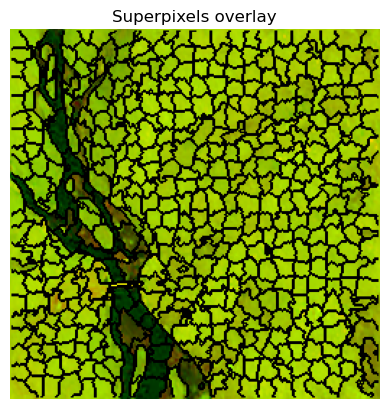

In [138]:
# Load the output 

superpixels_img = Image.open("../../image/sar_snic_500.png")
print(superpixels_img)

plt.imshow(superpixels_img)
plt.title('Superpixels overlay')
plt.axis('off')
plt.show()

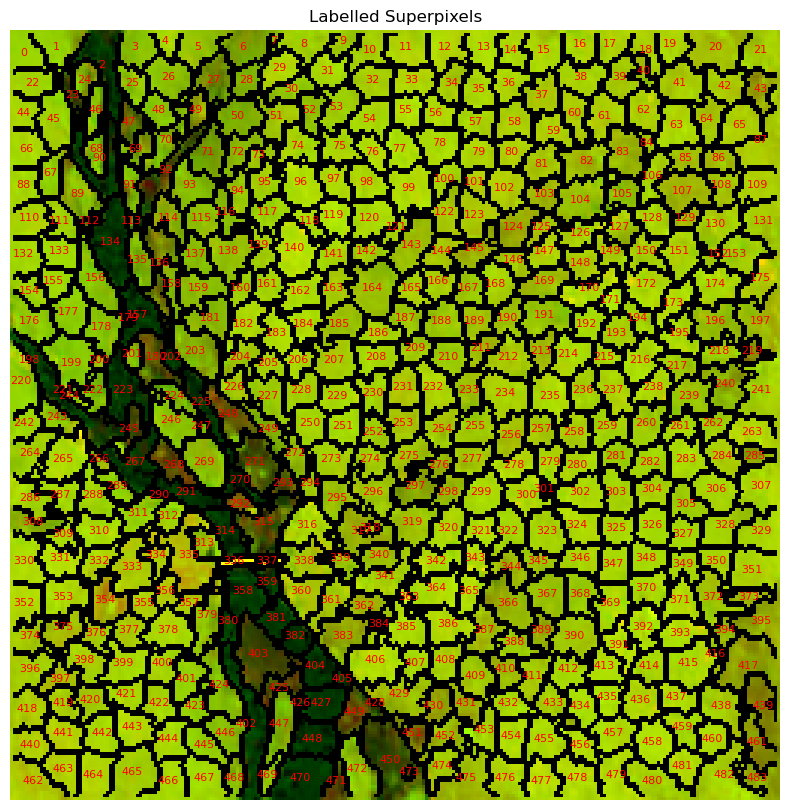

In [24]:
# Plot again with superpixel ID labels

plt.figure(figsize=(10, 10))
plt.imshow(superpixels_img)
plt.title("Labelled Superpixels")

# Plot superpixel ID at its centroid
for sp_id in np.unique(labels):
    y_coords, x_coords = np.where(labels == sp_id)
    if len(x_coords) > 0:
        cx = int(np.mean(x_coords))
        cy = int(np.mean(y_coords))
        plt.text(cx, cy, str(sp_id), color='red', fontsize=8, ha='center', va='center')

plt.axis('off')
plt.show()


In [25]:
def std(regionmask, intensity_img):
    vals = intensity_img[regionmask]
    return np.std(vals)

def mean(regionmask, intensity_img):
    vals = intensity_img[regionmask]
    return np.mean(vals)

def compactness(regionmask):
    from skimage.measure import perimeter
    return 4 * np.pi * regionmask.sum() / (perimeter(regionmask)**2 + 1e-6)

def rectangularity(regionmask):
    return regionmask.sum() / regionmask.size

from scipy import stats
def entropy_sar(regionmask, intensity_img):
    vals = intensity_img[regionmask]
    arr = stats.relfreq(vals, 100, defaultreallimits=(0, 255))[0]
    return stats.entropy(arr)

In [58]:

def calc_sar_feats(seg_arr, img_arr):
    # Spectral features for each SAR band
    spectral_feats = []
    for band in range(img_arr.shape[-1]):
        props = regionprops_table(
            label_image=seg_arr,
            intensity_image=img_arr[:, :, band],
            properties=["label", "mean_intensity"],
            extra_properties=(std, mean)
        )
        spectral_feats.append(pd.DataFrame(props).add_suffix(f"_b{band+1}"))

    # Shape features
    shape_feats = pd.DataFrame(
        regionprops_table(
            label_image=seg_arr,
            properties=["solidity"],
            extra_properties=(compactness, rectangularity)
        )
    )

    # Texture (using band 1, or change to preferred band)
    textural_feats = pd.DataFrame(
        regionprops_table(
            label_image=seg_arr,
            intensity_image=img_arr[:, :, 0],
            properties=[],
            extra_properties=(entropy_sar,)
        )
    )

    # Combine all
    all_feats = pd.concat(spectral_feats + [shape_feats, textural_feats], axis=1)

    # Rename columns for clarity
    rename_dict = {
        'label_b1': 'segment_id',
        'mean_intensity_b1': 'mean_intensity_vv',
        'std_b1': 'std_vv',
        'mean_b1': 'mean_vv',
        'mean_intensity_b2': 'mean_intensity_vh',
        'std_b2': 'std_vh',
        'mean_b2': 'mean_vh',
        'label_b3': 'segment_id',
        'mean_intensity_b3': 'mean_intensity_ration',
        'std_b3': 'std_ratio',
        'mean_b3': 'mean_ratio'       
    }
    all_feats = all_feats.rename(columns=rename_dict)

    return all_feats

In [78]:
features_df = calc_sar_feats(labels, imgname)
features_df = features_df.loc[:, ~features_df.columns.duplicated()]  # remove duplicate 'label' cols
features_df = features_df.rename(columns={'label_b1': 'segment_id'})
features_df.head(381)

#features_df.shape[1]

,segment_id,mean_intensity_vv,std_vv,mean_vv,label_b2,mean_intensity_vh,std_vh,mean_vh,mean_intensity_ration,std_ratio,mean_ratio,solidity,compactness,rectangularity,entropy_sar
0,1,109.391813,61.158444,109.391813,1,151.485380,85.824475,151.485380,0.000000,0.000000,0.000000,0.822115,0.521721,0.475000,2.396858
1,2,5.036585,10.518406,5.036585,2,35.434959,25.868685,35.434959,0.004065,0.063628,0.004065,0.622785,0.370982,0.440860,1.265344
2,3,104.034014,57.350980,104.034014,3,146.217687,80.477446,146.217687,0.000000,0.000000,0.000000,0.885542,0.801557,0.653333,2.261885
3,4,119.223881,75.224206,119.223881,4,153.358209,96.568080,153.358209,0.000000,0.000000,0.000000,0.881579,0.827403,0.553719,2.080982
4,5,115.439490,61.205130,115.439490,5,150.636943,79.427582,150.636943,0.000000,0.000000,0.000000,0.857923,0.681650,0.590226,2.534749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,377,114.509259,77.693307,114.509259,377,137.805556,93.518810,137.805556,0.000000,0.000000,0.000000,0.892562,0.789700,0.692308,1.880233
377,378,123.463687,75.885113,123.463687,378,156.111732,95.888488,156.111732,0.000000,0.000000,0.000000,0.848341,0.666071,0.588816,1.958408
378,379,78.623596,70.980049,78.623596,379,104.005618,93.582235,104.005618,0.000000,0.000000,0.000000,0.714859,0.319840,0.410138,2.298480
379,380,0.342466,1.859586,0.342466,380,28.698630,33.527206,28.698630,0.000000,0.000000,0.000000,0.640351,0.503306,0.414773,0.216560


In [131]:
low_vh = features_df[features_df["mean_vv"] < 10]
#print(low_vh)
print(low_vh[["segment_id", "mean_intensity_vv", "mean_intensity_vh", 'label_b2', 'mean_ratio']])

     segment_id  mean_intensity_vv  mean_intensity_vh  label_b2  mean_ratio
1             2           5.036585          35.434959         2    0.004065
89           90           2.948837          26.734884        90    0.000000
111         112           4.300000           6.150000       112    0.000000
133         134           0.568966          38.234483       134    0.000000
156         157           0.083770          31.356021       157    0.000000
178         179           0.000000           4.333333       179    0.000000
197         198           0.000000           0.000000       198    0.000000
201         202           0.375000          24.833333       202    0.000000
220         221           0.000000           0.000000       221    0.000000
222         223           0.970588          32.941176       223    0.000000
224         225           2.267176          27.755725       225    0.000000
243         244           7.032573          37.866450       244    0.006515
266         

In [129]:
high_ratio = features_df[features_df["mean_ratio"] > 0.1]
#print(low_vh)
print(high_ratio[["segment_id", "mean_intensity_vv", "mean_intensity_vh", 'label_b2', 'mean_ratio']])

     segment_id  mean_intensity_vv  mean_intensity_vh  label_b2  mean_ratio
46           47          52.794118          60.205882        47    0.147059
91           92          34.156682          37.603687        92    0.304147
135         136          60.746341          67.878049       136    0.107317
151         152          77.333333          70.333333       152    0.333333
179         180          49.726316          51.378947       180    0.268421
218         219          54.200000          55.111111       219    0.200000
244         245          37.428571          44.054945       245    0.109890
247         248          67.423529          63.552941       248    0.458824
267         268          57.335664          46.125874       268    0.552448
291         292          72.609375          61.234375       292    0.468750
292         293          38.630769          39.384615       293    0.230769
314         315          48.752941          56.054902       315    0.247059
334         

In [132]:
# can map the superpixels id selected 

#Band 1 = VV - the backscatter for water is 0
# Band 2 = VH
# Band 3 = ratio of vv and vh :vv_vh

# Sample indices of superpixels labeled as water and non-water
water_idxs = [2, 90, 112, 134, 179, 198, 221, 223, 225, 267, 270, 291, 301, 358, 359, 426, 470, 473] # Example water superpixel indices
non_water_idxs = [3, 25, 50, 87, 100, 150, 170, 193, 210, 227, 260, 280, 310, 318, 330, 450, 465, 477, 481] # Example non-water superpixel indices

# Initialize the 'class' column to -1 (unlabeled)
features_df['class'] = -1

# Assign class label 1 to water
features_df.loc[features_df['segment_id'].isin(water_idxs), 'class'] = 1

# Assign class label 0 to non-water
features_df.loc[features_df['segment_id'].isin(non_water_idxs), 'class'] = 0

# Display the labeled DataFrame (optional)
display(features_df)

,segment_id,mean_intensity_vv,std_vv,mean_vv,label_b2,mean_intensity_vh,std_vh,mean_vh,mean_intensity_ration,std_ratio,mean_ratio,solidity,compactness,rectangularity,entropy_sar,class
0,1,109.391813,61.158444,109.391813,1,151.485380,85.824475,151.485380,0.000000,0.000000,0.000000,0.822115,0.521721,0.475000,2.396858,-1
1,2,5.036585,10.518406,5.036585,2,35.434959,25.868685,35.434959,0.004065,0.063628,0.004065,0.622785,0.370982,0.440860,1.265344,1
2,3,104.034014,57.350980,104.034014,3,146.217687,80.477446,146.217687,0.000000,0.000000,0.000000,0.885542,0.801557,0.653333,2.261885,0
3,4,119.223881,75.224206,119.223881,4,153.358209,96.568080,153.358209,0.000000,0.000000,0.000000,0.881579,0.827403,0.553719,2.080982,-1
4,5,115.439490,61.205130,115.439490,5,150.636943,79.427582,150.636943,0.000000,0.000000,0.000000,0.857923,0.681650,0.590226,2.534749,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478,479,132.372881,76.352786,132.372881,479,164.124294,94.534341,164.124294,0.000000,0.000000,0.000000,0.740586,0.506247,0.614583,2.275039,-1
479,480,127.177665,66.416039,127.177665,480,162.329949,84.774157,162.329949,0.000000,0.000000,0.000000,0.875556,0.585185,0.571014,2.258390,-1
480,481,120.404959,81.597437,120.404959,481,148.371901,100.444149,148.371901,0.000000,0.000000,0.000000,0.876812,0.777842,0.664835,2.049006,0
481,482,127.428044,68.919932,127.428044,482,160.760148,87.339846,160.760148,0.000000,0.000000,0.000000,0.726542,0.390752,0.513258,2.335567,-1


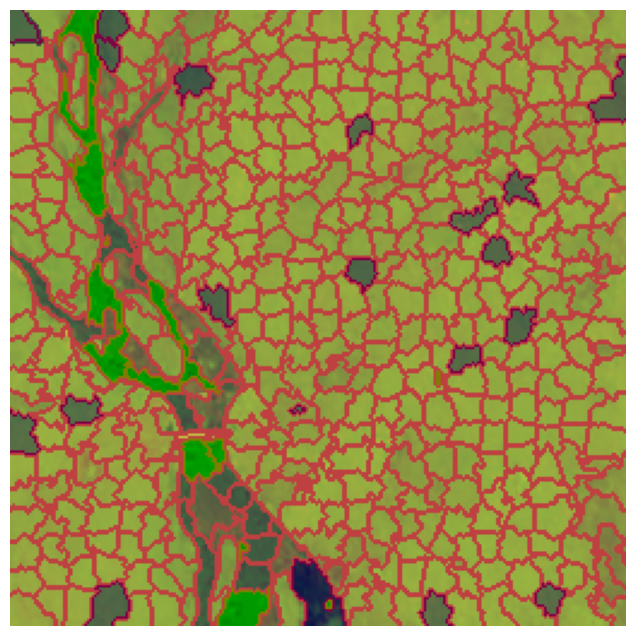

In [133]:
# Map the labeled segments onto the original segmented image

mapped_samples = map_array(
    labels,
    np.array(features_df["segment_id"]),
    np.array(features_df["class"])
)


# Display the original image with segment boundaries
plt.figure(figsize=(12, 8))
plt.imshow(mark_boundaries(imgname, labels, (1, 0, 0), mode="outer"))

background_c, nonwater_c, water_c = '#7f8282', '#00008b', '#00FF00'
binary_cmap = mcolors.ListedColormap([background_c, nonwater_c, water_c])
# Overlay the labeled segments with the defined colors
plt.imshow(mapped_samples, cmap=binary_cmap, alpha=0.5)

# Turn off the axis for a cleaner look
plt.axis("off")

# Show the plot
plt.show()

In [134]:

# Filter out the labeled samples
labeled_segments_df = features_df[features_df['class'] != -1]

# Separate features (X) and class label (y)
X = labeled_segments_df.drop(columns=['segment_id', 'class'])
y = labeled_segments_df['class']

# Train the Random Forest Classifier using the entire dataset
clf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
clf.fit(X, y)

# Evaluate the model using OOB score
print("OOB Score:", clf.oob_score_)

OOB Score: 0.972972972972973


In [135]:
# Filter out the unlabeled segments
unlabeled_segments_df = features_df[features_df['class'] == -1]

# Separate features (X) for the unlabeled segments
X = unlabeled_segments_df.drop(columns=['segment_id', 'class'])

# Predict the class labels for the unlabeled segments
predictions = clf.predict(X)

# Update the original dataframe with the predictions
features_df.loc[features_df['class'] == -1, 'class'] = predictions

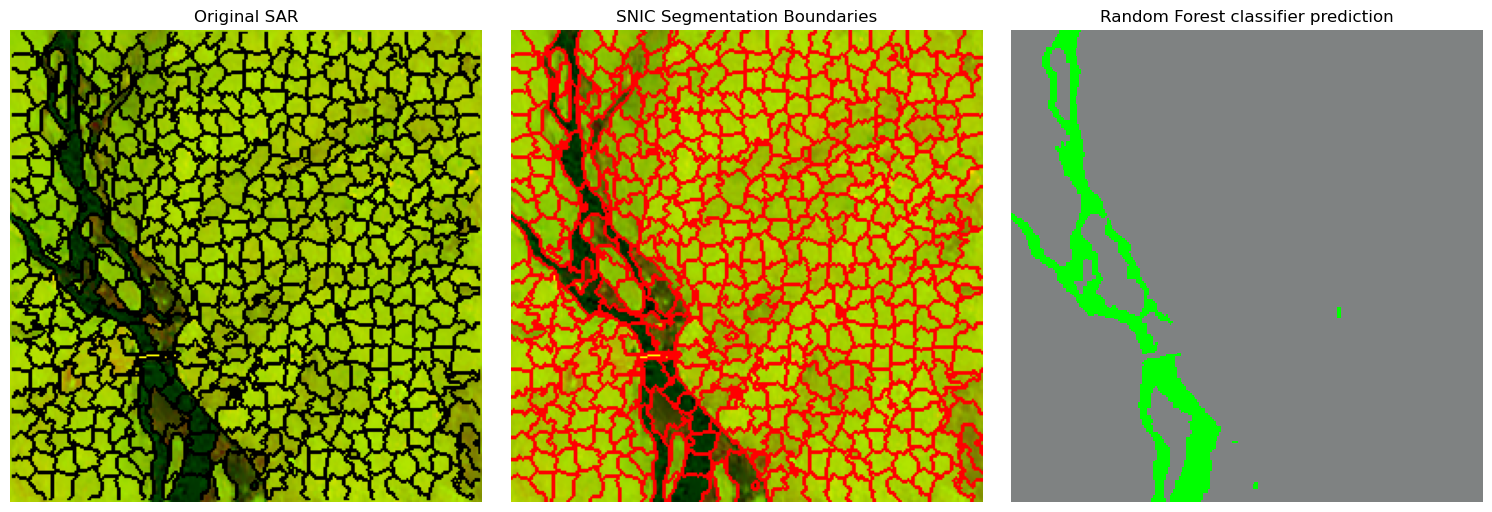

In [136]:
#  Map the predictions onto the original segmented image
mapped_rf_classification= map_array(
    labels,
    np.array(features_df["segment_id"]),
    np.array(features_df["class"]))

# Create the figure with 3 subplots
fig, axs = plt.subplots(ncols=3, figsize=(15, 5), constrained_layout=True)

# Display the original RGB image
axs[0].imshow(img)
axs[0].set_title("Original SAR")

# Display the RGB image with segmentation boundaries for 3000 segments
axs[1].imshow(mark_boundaries(imgname, labels, color=(1, 0, 0), mode="thick"))
axs[1].set_title(f"SNIC Segmentation Boundaries")

# Display the prediction result
axs[2].imshow(mapped_rf_classification, cmap=binary_cmap, interpolation="nearest")
axs[2].set_title("Random Forest classifier prediction")

# Remove axis for all subplots
for ax in axs:
    ax.set_axis_off()

# Display the combined figure
plt.show()
